In [35]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
from pathlib import Path
import datetime
import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots
from collections import defaultdict
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
colorblind = sns.color_palette("colorblind")
hsv = sns.color_palette("hsv")
sns.set_style("whitegrid")

sns.set_palette(colors)
# sns.set_palette(colorblind[::-1])


from tueplots import bundles, fontsizes, figsizes
plt.rcParams.update({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()})
matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots


from wbml import plot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Locations

In [2]:
img_folder = 'tmp'

In [3]:
include_adult_a = {
    # GVI
    "results_newer/Adult/A/GVI/08-06-08.42.32_seq-gi-adult-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Adult/A/GVI/08-06-08.26.23_seq-gi-adult-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Adult/A/GVI/08-07-11.41.00_seq-mfvi-adult-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Adult/A/GVI/08-07-11.42.16_seq-mfvi-adult-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",

    # Seq
    "results_newer/Adult/A/Seq/08-06-10.59.17_seq-gi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Adult/A/Seq/08-06-14.13.05_seq-gi-adult-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Adult/A/Seq/08-07-11.37.42_seq-mfvi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Adult/A/Seq/08-07-11.37.42_seq-mfvi-adult-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",

    # Sync
    "results_newer/Adult/A/Sync/08-07-12.28.57_sync-gi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Adult/A/Sync/08-07-12.29.44_sync-mfvi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
    "results_newer/Adult/A/Sync/08-07-12.29.44_sync-mfvi-adult-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
}

include_adult_b = {
    # Seq
    "results_newer/Adult/B/Seq/08-07-09.22.24_seq-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Adult/B/Seq/08-07-12.25.10_seq-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p",

    # Sync
    "results_newer/Adult/B/Sync/08-07-09.08.41_sync-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
    "results_newer/Adult/B/Sync/08-07-09.12.11_sync-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p"
}

In [4]:
include_bank_a = {
    # GVI
    # "results_newer/Bank/A/GVI/08-04-04.49.06_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    # "results_newer/Bank/A/GVI/08-04-04.24.43_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    
    # "results_newer/Bank/A/GVI/08-04-18.55.32_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-100p",
    # "results_newer/Bank/A/GVI/08-04-20.44.41_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-100p",

    # "results_newer/Bank/A/GVI/08-04-09.28.52_seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",
    # "results_newer/Bank/A/GVI/08-04-09.28.44_seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",

    "results_newer/Bank/A/GVI/08-06-08.31.47_seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/GVI/08-06-08.32.55_seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/GVI/08-06-12.08.54_seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Bank/A/GVI/08-06-12.09.20_seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",

    # Seq
    "results_newer/Bank/A/Seq/08-04-01.47.16_seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Seq/08-04-13.42.19_seq-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p",
    # "results_newer/Bank/A/Seq/08-04-01.51.34_seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    # "results_newer/Bank/A/Seq/08-04-09.30.36_seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",

    "results_newer/Bank/A/Seq/08-08-16.51.24_seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Seq/08-08-16.51.24_seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p",

    # Sync
    "results_newer/Bank/A/Sync/08-05-22.11.06_sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/A/Sync/08-05-22.14.31_sync-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p", 
    "results_newer/Bank/A/Sync/08-05-22.27.03_sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
}

include_bank_b = {
    # Seq
    "results_newer/Bank/B/Seq/08-07-08.38.23_seq-gi-bank-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/B/Seq/08-07-08.38.23_seq-mfvi-bank-10c-10g-10000l-std-splitb-256b-0-001lr-2s-rand-mean-20p",
    "results_newer/Bank/B/Seq/08-07-08.56.34_seq-mfvi-bank-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-20p",

    # Sync
    "results_newer/Bank/B/Sync/08-07-08.38.23_sync-gi-bank-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p",
    "results_newer/Bank/B/Sync/08-07-08.38.23_sync-mfvi-bank-10c-10g-10000l-std-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
    "results_newer/Bank/B/Sync/08-07-08.39.01_sync-mfvi-bank-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p",
}

In [5]:
########### READ LOG FILES ###########

main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
res = "results_newer/"
res_dir = os.path.join(main_dir, res)

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
logs = infinite_defaultdict()

# Column headers
pvi_name = "PVI"
variational_name = "Method"
client_name = "Client"
split_name = "Split"
dataset_name = 'Dataset'
experiment_name ='Experiment name'
num_clients_name = 'Number of clients'
prior_name = 'Prior'

for dataset_type in os.listdir(res_dir):
    if dataset_type in ["Adult", "Bank", "Credit"]:
        for split_type in os.listdir(os.path.join(res_dir, dataset_type)):
            for pvi_type in os.listdir(os.path.join(res_dir, dataset_type, split_type)):
                
                exp_dir = os.path.join(res_dir, dataset_type, split_type, pvi_type)

                for exp in os.listdir(exp_dir):
                    q_type = exp.split('_')[1].split('-')[1]
                    num_clients = int(exp.split('_')[1].split('-')[3].split('c')[0])
                    # Erroneous file naming
                    if q_type == 'pvi': q_type = 'gi'
                    
                    metrics_dir = os.path.join(exp_dir, exp, "metrics")
                    _exp_name = '-'.join(exp.split('_')[1:])
                    prior_type = 'Std' if 'std' in _exp_name else 'Neal'

                    # Exclude experiments in array
                    x = os.path.join(res, dataset_type, split_type, pvi_type, exp)
                    if x in include_adult_a or x in include_bank_a or x in include_bank_b or x in include_adult_b:
                        
                        current_df = logs[dataset_type][pvi_type][split_type][q_type][prior_type]

                        # Existing log file
                        if type(current_df[experiment_name]) == str:
                            # OVERWRITE EXISTING LOG FILE
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}/{prior_type}: {current_df[experiment_name]} ==> {_exp_name}")
                        else:
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}/{prior_type} = {_exp_name}")

                        # Set logs[...] to current experiment
                        current_df[experiment_name] = _exp_name
                        
                        # Load metrics
                        for log_name in os.listdir(metrics_dir):
                            name = log_name.split('_')[0]
                            
                            current_df[name] = pd.read_csv(os.path.join(metrics_dir, log_name))

                            # Add column values
                            current_df[name][pvi_name] = pvi_type.upper()
                            current_df[name][variational_name] = q_type.upper()
                            current_df[name][split_name] = split_type.upper()
                            current_df[name][dataset_name] = dataset_type
                            current_df[name][prior_name] = prior_type
                            if name != 'server':
                                current_df[name][client_name] = name
                            current_df[name][num_clients_name] = num_clients
                            current_df[name][experiment_name] = _exp_name

Bank/Seq/A/gi/Neal = seq-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/Seq/A/mfvi/Neal = seq-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Seq/A/mfvi/Std = seq-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Seq/A/gi/Std = seq-gi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/gi/Neal = seq-gi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/mfvi/Neal = seq-mfvi-bank-1c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-20p
Bank/GVI/A/gi/Std = seq-gi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p
Bank/GVI/A/mfvi/Std = seq-mfvi-bank-1c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-20p
Bank/Sync/A/gi/Neal = sync-gi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p
Bank/Sync/A/mfvi/Std = sync-mfvi-bank-10c-10g-10000l-std-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p
Bank/Sync/A/mfvi/Neal = sync-mfvi-bank-10c-10g-10000l-neal-splita-256b-0-001lr-2s-rand-mean-damp-0-2-20p
Bank/S

Merge dataframes for plotting purposes.

In [6]:
clients = []
for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for prior_setting, ddddd in dddd.items():
                    for name, log in ddddd.items():
                        if name != experiment_name and name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [7]:
servers = []

for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for prior_setting, ddddd in dddd.items():
                    for name, log in ddddd.items():
                        if name != experiment_name and name == 'server': servers.append(log)

server = pd.concat(servers, ignore_index=True)

In [8]:
server.groupby(by=[variational_name, dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Method  Dataset  Split  PVI   Split  Method  Experiment name                                                                  
GI      Adult    A      GVI   A      GI      seq-gi-adult-1c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                        11
                                             seq-gi-adult-1c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                         11
                        SEQ   A      GI      seq-gi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                       78
                                             seq-gi-adult-10c-10g-10000l-std-splita-256b-0-001lr-2s-10m-20p                       101
                        SYNC  A      GI      sync-gi-adult-10c-10g-10000l-neal-splita-256b-0-001lr-2s-10m-20p                      11
                 B      SEQ   B      GI      seq-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                      101
                        SYNC  B      GI      sync-gi-adult-10c-10g-10

# Plotting

### Split B

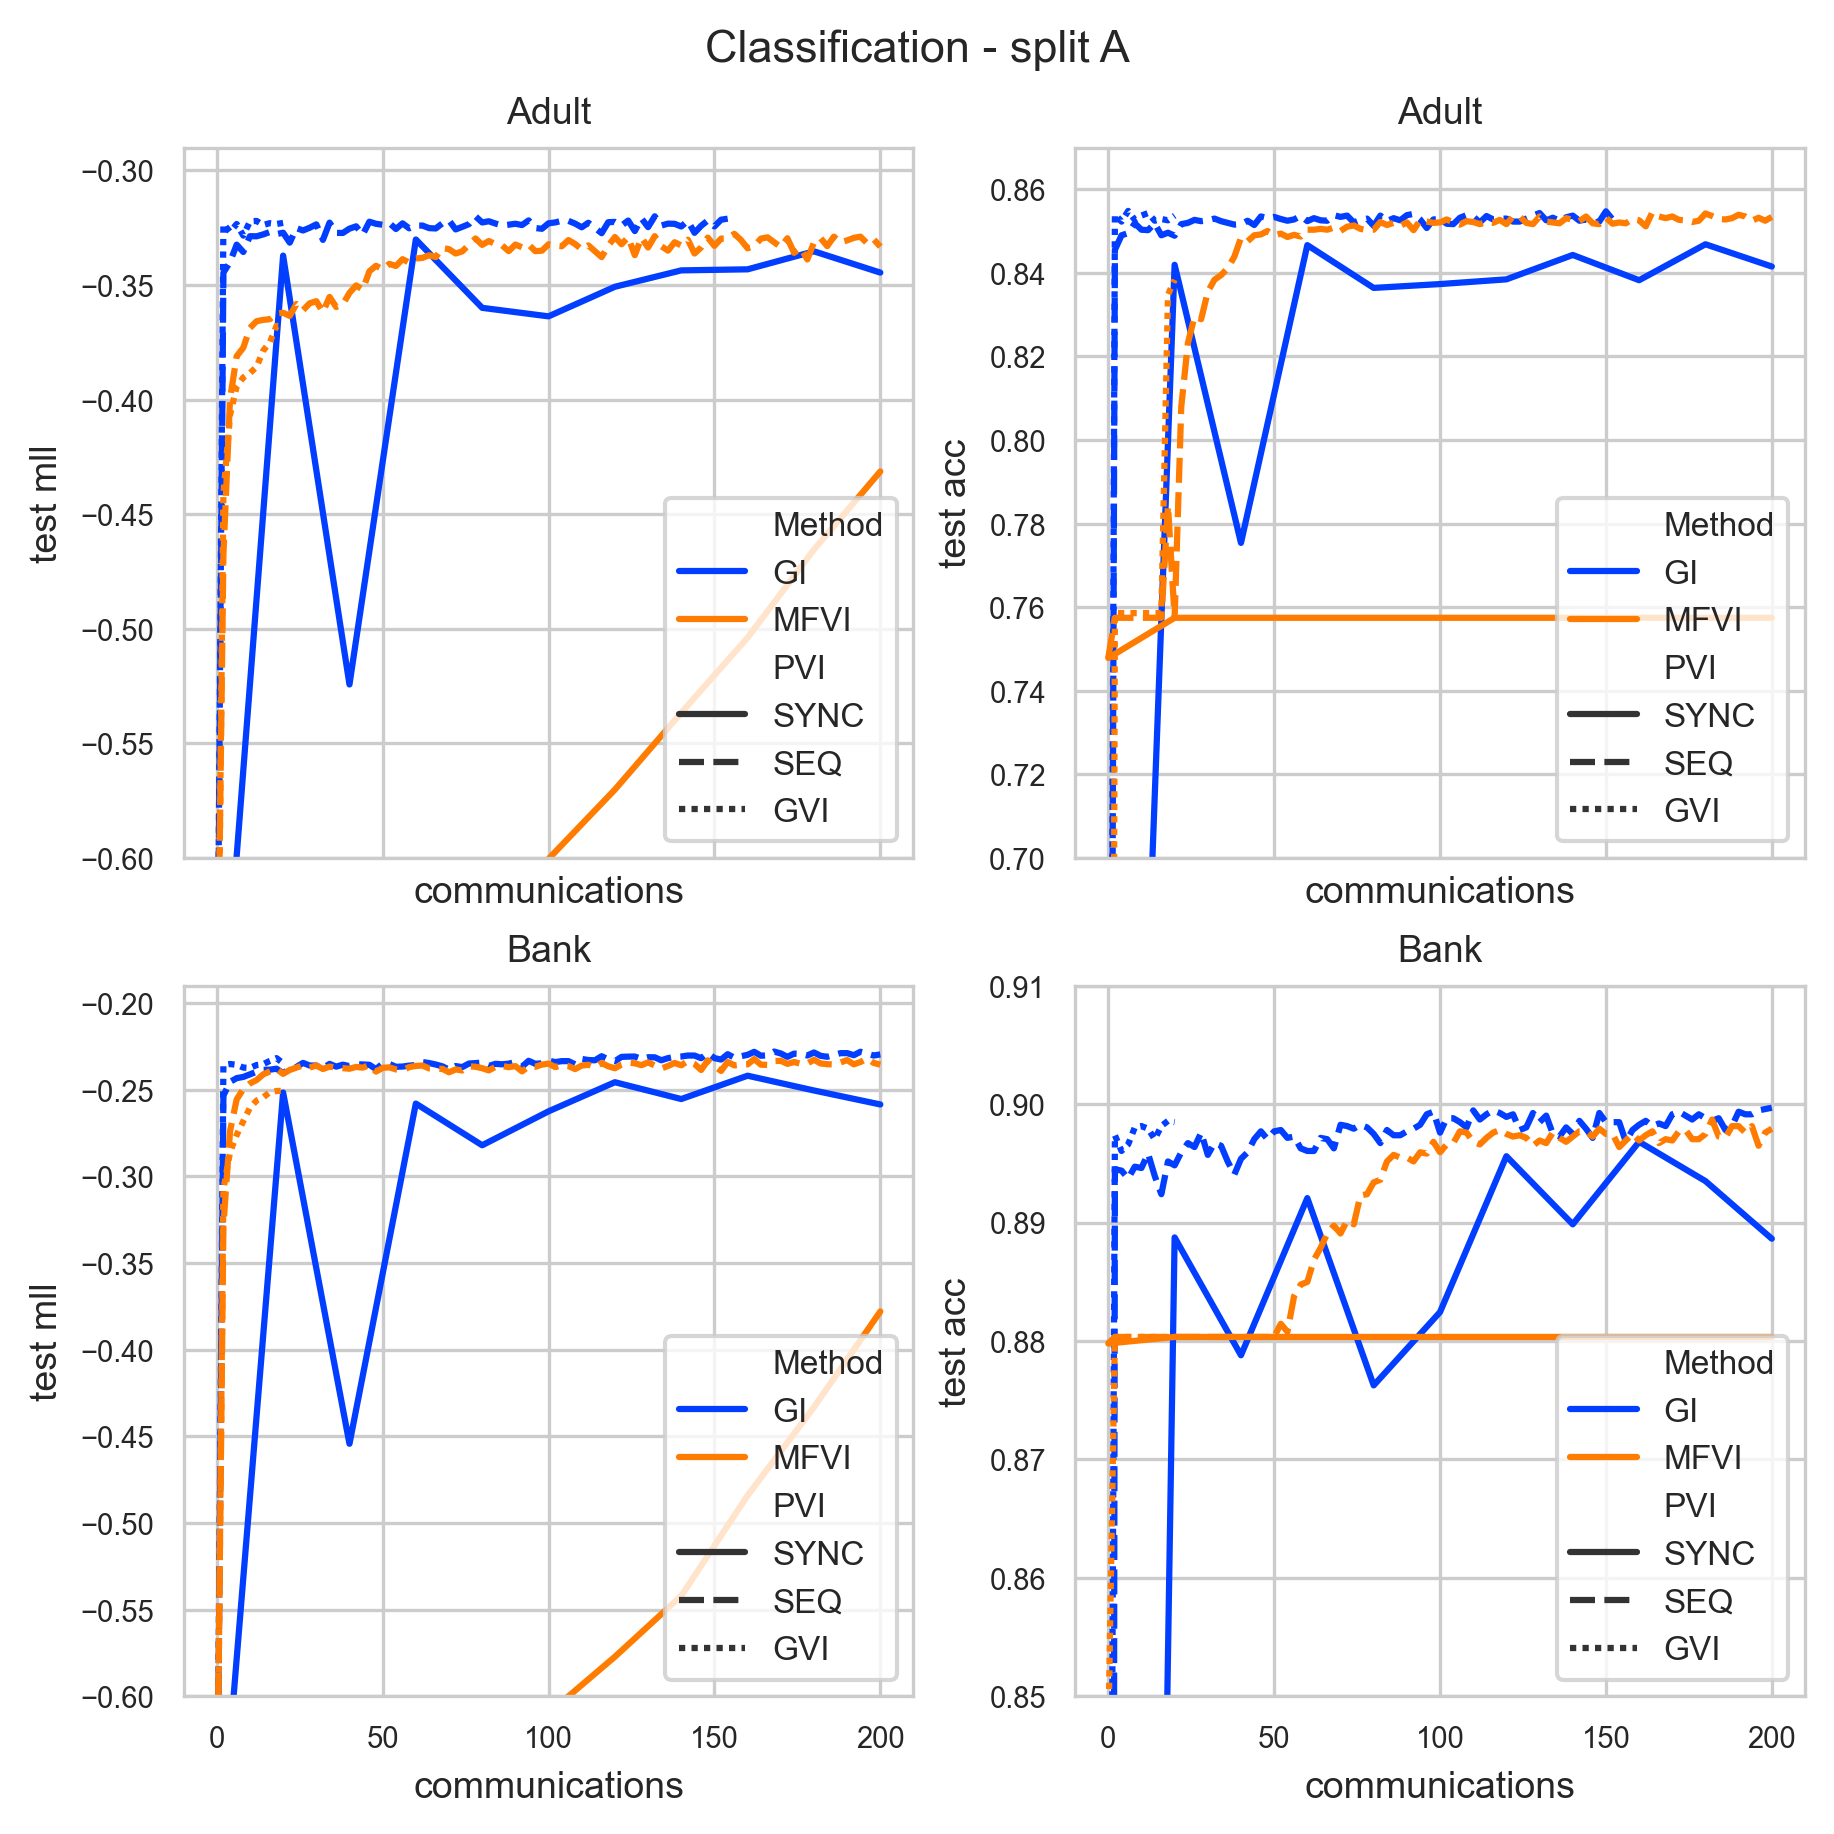

In [38]:
_split = "A"
folders = {
            "T": server.loc[(server[dataset_name] == "Adult") & (server[split_name] == _split) & (server[prior_name] == "Neal")],
            "B": server.loc[(server[dataset_name] == "Bank") & (server[split_name] == _split) & (server[prior_name] == "Neal")],
        }

fig, axs = plt.subplots(2, 2, figsize=(6,6))
fig.suptitle(f"Classification - split {_split}")

axes = {"TL": axs[0,0], "TR": axs[0,1], "BL": axs[1,0], "BR": axs[1,1]}

for row, data in folders.items():
    data = data.sort_values(by=[variational_name, pvi_name, split_name, dataset_name, prior_name, experiment_name, 'communications'], ascending=[True, False, True, True, True, True, True])

    ax_mll = axes[row+"L"]
    ax_acc = axes[row+"R"]

    x_metric = 'communications'

    # sns.lineplot(data=data, x=x_metric, y='test_mll', ax=ax_mll, hue=pvi_name, style=variational_name)
    # sns.lineplot(data=data, x=x_metric, y='test_acc', ax=ax_acc, hue=pvi_name, style=variational_name)

    sns.lineplot(data=data, x=x_metric, y='test_mll', ax=ax_mll, style=pvi_name, hue=variational_name)
    sns.lineplot(data=data, x=x_metric, y='test_acc', ax=ax_acc, style=pvi_name, hue=variational_name)


    ax_mll.set_ylabel("test mll")
    ax_acc.set_ylabel("test acc")
    
    ax_mll.legend(loc="lower right", prop={"size": 8})
    ax_acc.legend(loc="lower right", prop={"size": 8})


    if _split == "B":
        if row == 'T':
            ax_mll.set_ylim(-.6,-0.29)
            ax_acc.set_ylim(0.7,0.87)
        else:
            ax_mll.set_ylim(-.6,-0.19)
            ax_acc.set_ylim(0.85,0.91)
    else:
        
        if row == 'T':
            ax_mll.set_ylim(-.6,-0.29)
            ax_acc.set_ylim(0.7,0.87)
        else:
            ax_mll.set_ylim(-.6,-0.19)
            ax_acc.set_ylim(0.85,0.91)
        
    
# IF you want titles, do it here:
titles = {"TL": "Adult", "TR": "Adult", "BL": "Bank", "BR": "Bank"}
for loc, ax_title in titles.items():
    if ax_title != "":
        axes[loc].set_title(ax_title)

# # Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([a.get_xticklabels() for a in axs[0, :]], visible=False)
# plt.setp([a.get_yticklabels() for a in axs[:, 1]], visible=False)

plt.show()

## Individual

test mll

In [178]:
dataset = "Adult"
split = "B"
omit_sync_mfvi = False
save_plot = False

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]
# data = data.loc[data[pvi_name] != 'SYNC']
# data = data.loc[data[prior_name] == 'Neal']

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, prior_name, experiment_name, 'communications'])

append_file_name = ""

# Check whether these are the experiments you want to plot.
data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size()

Method  Dataset  Split  Prior  Experiment name                                                                  
GI      Adult    B      Neal   seq-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                      101
                               sync-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                       7
MFVI    Adult    B      Neal   seq-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-20p              101
                               sync-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p     11
dtype: int64

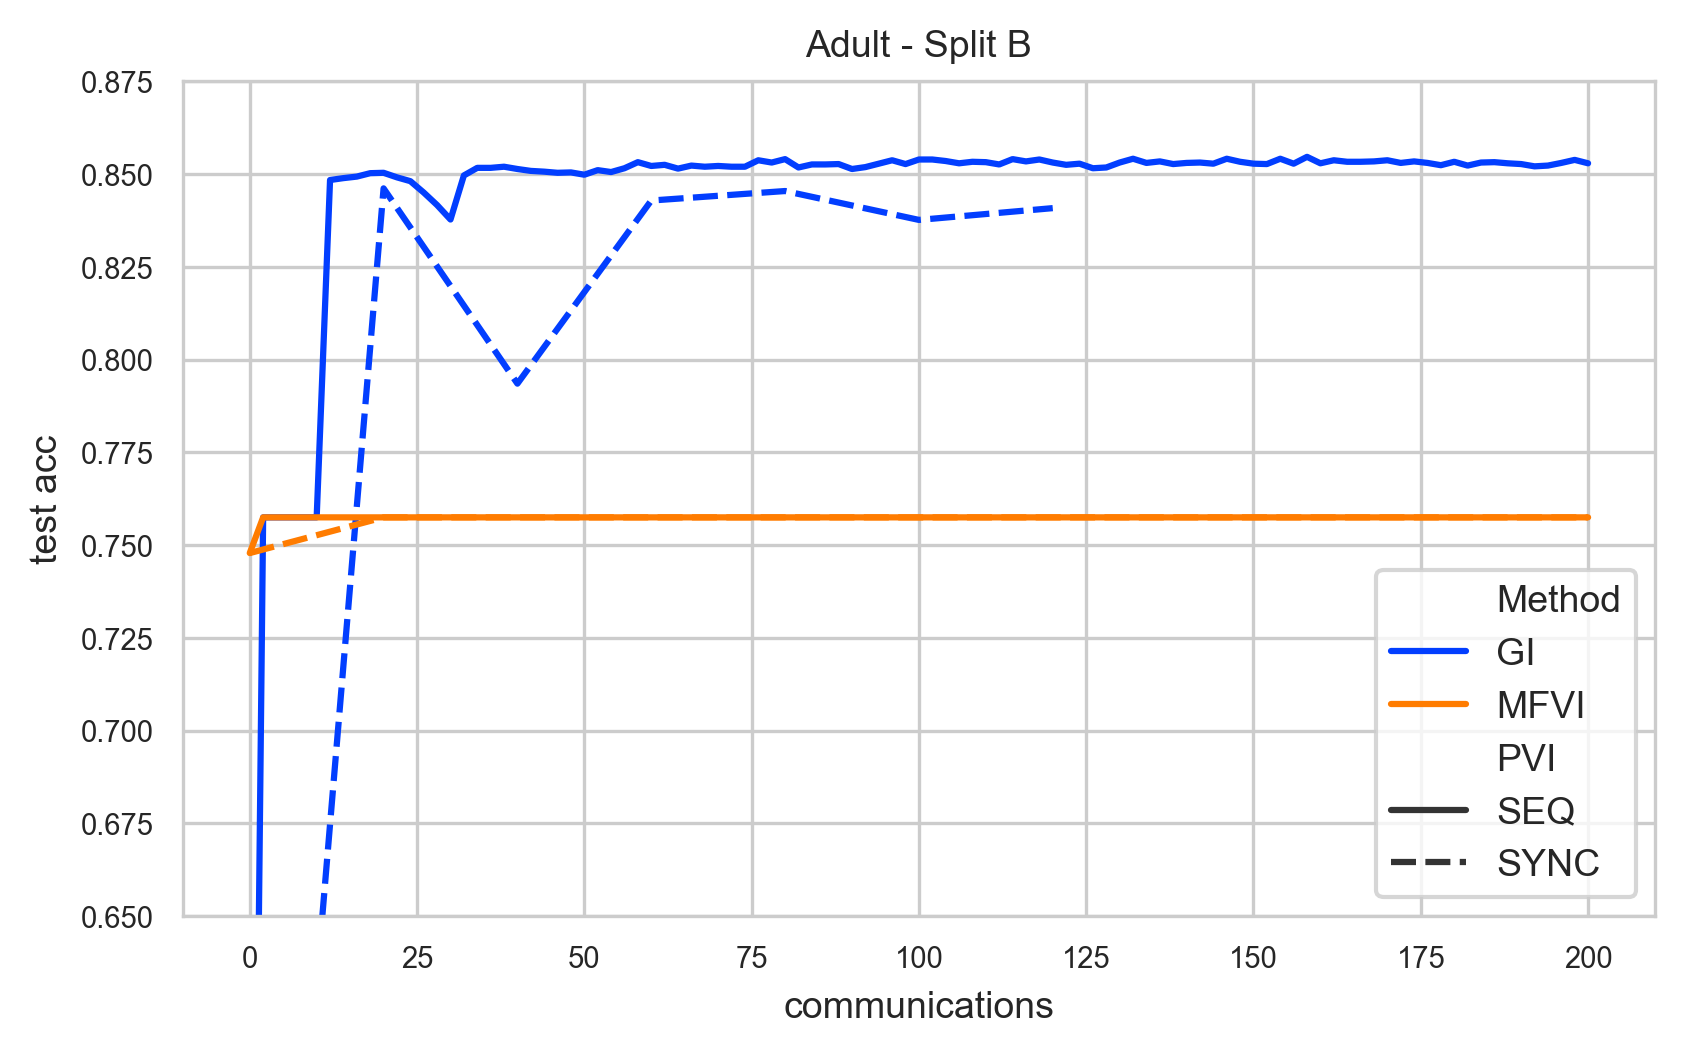

Method  Dataset  Split  Prior  Experiment name                                                                  
GI      Adult    B      Neal   seq-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                      101
                               sync-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                       7
MFVI    Adult    B      Neal   seq-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-20p              101
                               sync-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p     11
dtype: int64


In [179]:
_start = datetime.datetime.utcnow()
_time = _start.strftime("%m-%d-%H-%M")

with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_acc'
    
    # sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name, size=prior_name)
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    # ax.set_ylim(-.5, -0.25)
    ax.set_ylim(.65, .875)
    # ax.set_xlim(0, 25)
    # ax.set_ylim(-1, -0.25)

    ax.set_title(f'{dataset} - Split {split}')
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{dataset}_{split}_{_time}_server_{x_metric}_{y_metric}"
    # if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    file_name += append_file_name
    if save_plot: plt.savefig(file_name)
    plt.show()

print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())

### Client

In [39]:
client.columns

Index(['global_iteration', 'local_iteration', 'total_iteration', 'vfe', 'll',
       'kl', 'error', 'PVI', 'Method', 'Split', 'Dataset', 'Prior', 'Client',
       'Number of clients', 'Experiment name'],
      dtype='object')

In [40]:
def transform_row(r):
    if r[pvi_name] == 'SEQ':
        r['new_iteration'] = (r.global_iteration/10) * 10000 + r.local_iteration
    else:
        r['new_iteration'] = r.total_iteration
    return r

Client dynamics plot 

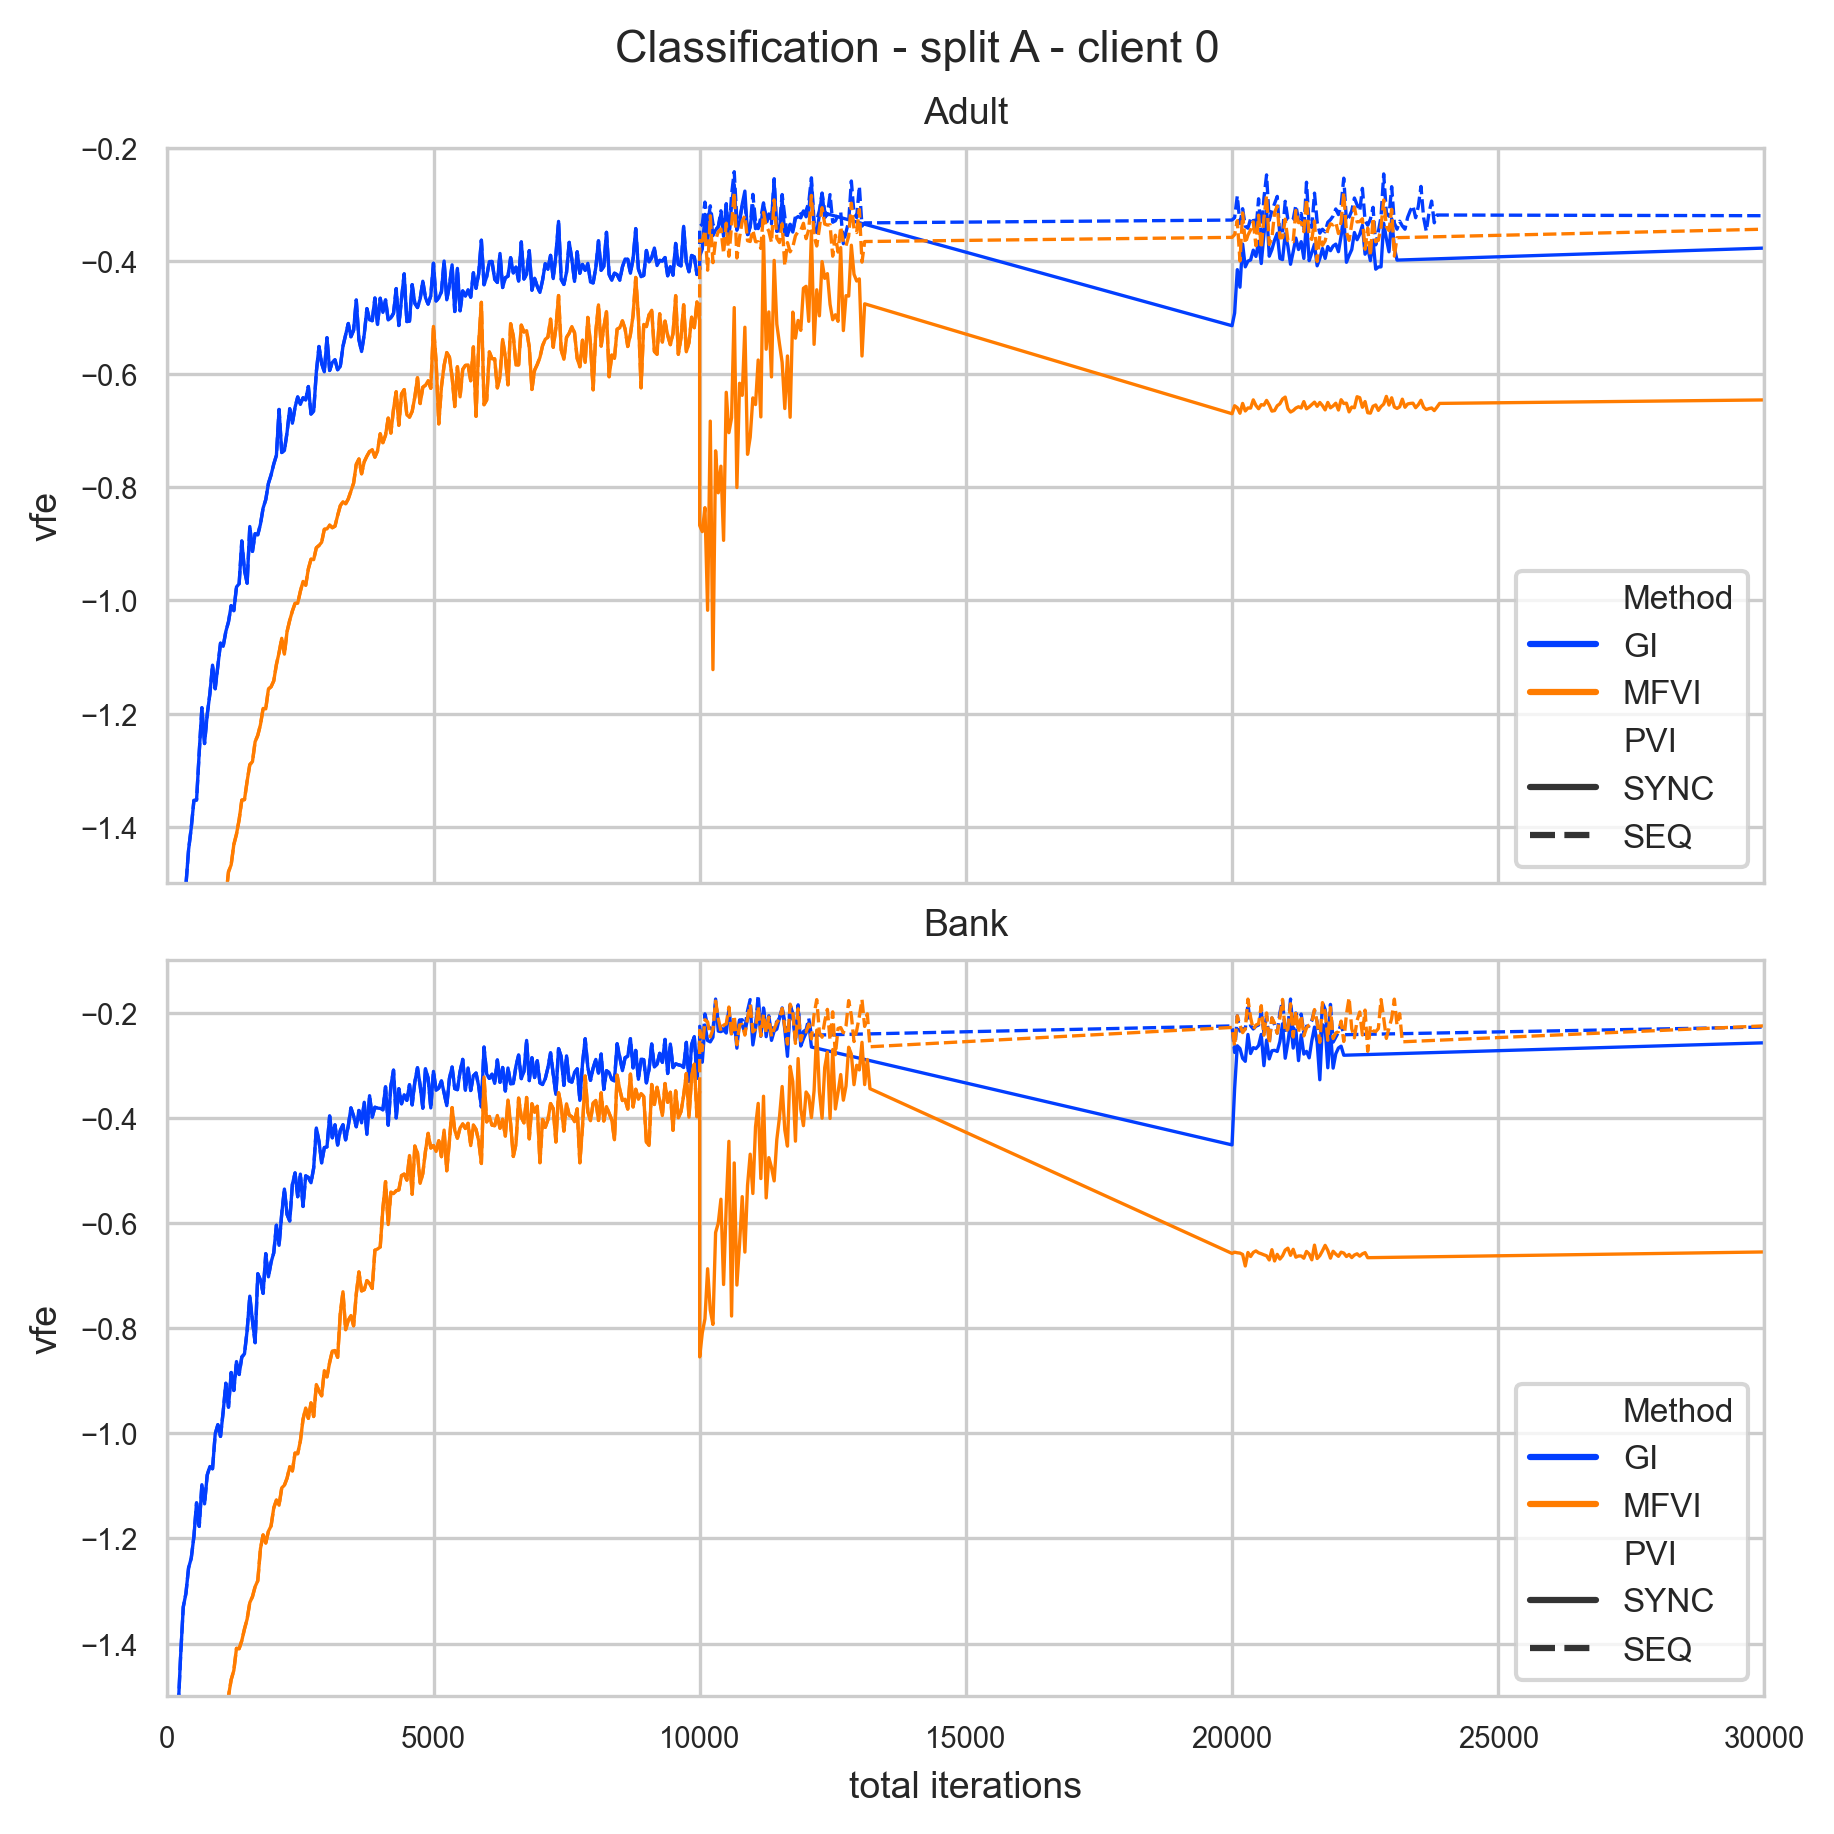

In [41]:
_split = "A"
_client = "0"
folders = {
            "T": client.loc[(client[dataset_name] == "Adult") & (client[split_name] == _split) & (client[prior_name] == "Neal")],
            "B": client.loc[(client[dataset_name] == "Bank") & (client[split_name] == _split) & (client[prior_name] == "Neal")],
        }

fig, axs = plt.subplots(2, 1, figsize=(6, 6))
fig.suptitle(f"Classification - split {_split} - client {_client}")

axes = {"T": axs[0], "B": axs[1]}

for row, data in folders.items():
    
    # Select specific client and exclude GVI
    data = data.loc[data[client_name] == f"client{_client}"].sort_values(by=[variational_name, pvi_name, split_name, dataset_name, prior_name, experiment_name, 'total_iteration'], ascending=[True, False, True, True, True, True, True])
    data = data.loc[data[pvi_name] != 'GVI']
    
    # Modify new column to adjust iteration tracker to plot SEQ & SYNC
    data = data.apply(transform_row, axis=1)
    x_metric = 'new_iteration'
    ax_mll = axes[row]

    sns.lineplot(data=data, x=x_metric, y='vfe', ax=ax_mll, hue=variational_name, style=pvi_name, linewidth=0.8)
    
    # Labels
    ax_mll.set_ylabel("vfe")
    if row == 'T':
        ax_mll.set_xlabel("")
        ax_mll.set_ylim(-1.5, -0.2)
    else:
        ax_mll.set_xlabel("total iterations")
        ax_mll.set_ylim(-1.5, -0.1)


    # Limits & legend    
    ax_mll.set_xlim(0, 3e4)
    ax_mll.legend(loc="lower right", prop={"size": 8})

# IF you want titles, do it here:
titles = {"T": "Adult", "B": "Bank"}
for loc, ax_title in titles.items():
    if ax_title != "":
        axes[loc].set_title(ax_title)

# Fine-tune figure; hide x ticks for top plots and y ticks for right plots
plt.setp([axes['T'].get_xticklabels()], visible=False)

plt.show()

Single 

In [17]:
dataset = "Adult"
split = "B"
_client = 0

omit_sync_mfvi = False
save_plot = False



data = client.loc[client[split_name] == split]
data = data.loc[data[dataset_name] == dataset]
# data = data.loc[data[pvi_name] != 'SYNC']
data = data.loc[data[prior_name] == 'Neal']
data = data.loc[data['Client'] == f"client{_client}"]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, pvi_name, split_name, dataset_name, experiment_name, 'total_iteration'], ascending=[True, False, True, True, True, True])

# Check whether these are the experiments you want to plot.
print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())

Method  Dataset  Split  Prior  Experiment name                                                                  
GI      Adult    B      Neal   seq-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                      680
                               sync-gi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-10m-20p                     475
MFVI    Adult    B      Neal   seq-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-20p              638
                               sync-mfvi-adult-10c-10g-10000l-neal-splitb-256b-0-001lr-2s-rand-mean-damp-0-2-20p    675
dtype: int64


NameError: name 'transform_row' is not defined

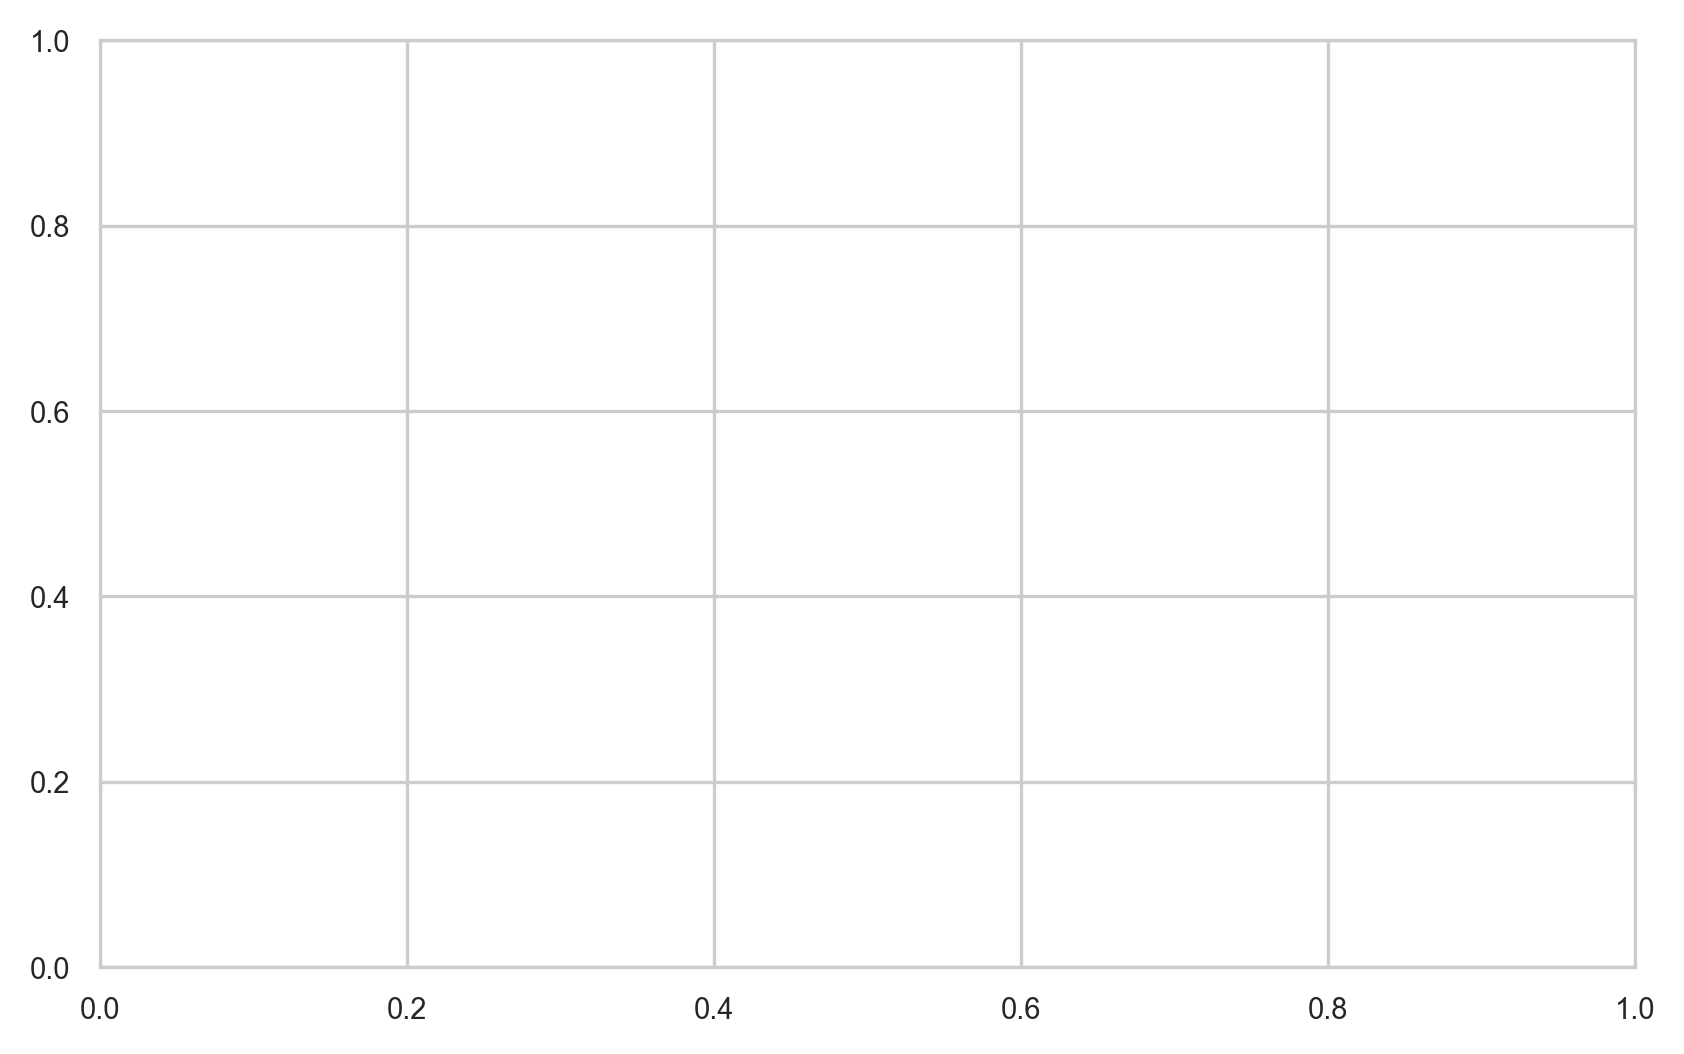

In [18]:
_start = datetime.datetime.utcnow()
_time = _start.strftime("%m-%d-%H-%M")
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    y_metric = "vfe"
    x_metric = "total_iteration"

    # Modify new column to adjust iteration tracker to plot SEQ & SYNC
    data = data.apply(transform_row, axis=1)
    x_metric = 'new_iteration'

    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name, linewidth=1)

    ax.set_title(f'{dataset} - Split {split} - Client {_client}')
    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    # ax.set_ylim(-1.0, -0.2)
    # ax.set_ylim(-2.5,0)
    ax.set_xlim(0, 1e5)

    file_name = f"./{img_folder}/{dataset}_{split}_{_time}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()

print(data.groupby(by=[variational_name, dataset_name, split_name, prior_name, experiment_name]).size())